In [66]:
import time
import math

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision as tv

In [67]:
# Используем Fasion MNIST https://github.com/zalandoresearch/fashion-mnist

BATCH_SIZE=1024
LABELS = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

train_dataset = tv.datasets.FashionMNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
test_dataset = tv.datasets.FashionMNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)
train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

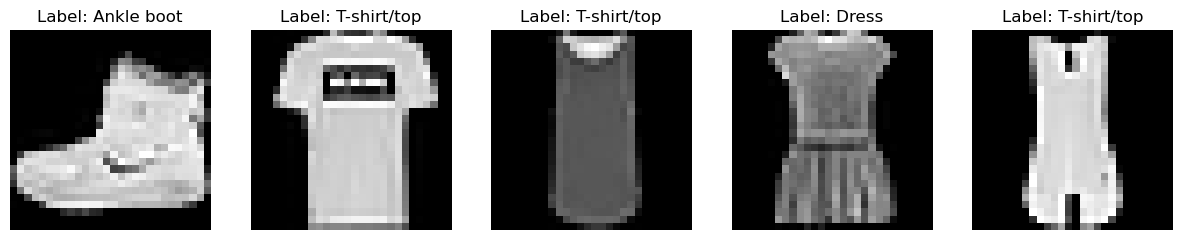

In [68]:
# Поглядим на примеры с лейблами из датасета

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img, label = train_dataset[i]
    axs[i].imshow(img.squeeze(), cmap='gray')
    axs[i].set_title(f'Label: {LABELS[label]}')
    axs[i].axis('off')
plt.show()

In [69]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 256),
    torch.nn.BatchNorm1d(256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(256, 10)
)

In [70]:
loss = torch.nn.CrossEntropyLoss()
trainer = torch.optim.Adam(model.parameters(), lr=.01)
num_epochs = 15

In [71]:
def train_model():
    for ep in range(num_epochs):
        train_iters, train_passed  = 0, 0
        train_loss, train_acc = 0., 0.
        start=time.time()
        
        model.train()
        for X, y in train:
            trainer.zero_grad()
            y_pred = model(X)
            l = loss(y_pred, y)
            l.backward()
            trainer.step()
            train_loss += l.item()
            train_acc += (y_pred.argmax(dim=1) == y).sum().item()
            train_iters += 1
            train_passed += len(X)
        
        test_iters, test_passed  = 0, 0
        test_loss, test_acc = 0., 0.
        model.eval()
        for X, y in test:
            y_pred = model(X)
            l = loss(y_pred, y)
            test_loss += l.item()
            test_acc += (y_pred.argmax(dim=1) == y).sum().item()
            test_iters += 1
            test_passed += len(X)
            
        print("ep: {}, taked: {:.3f}, train_loss: {}, train_acc: {}, test_loss: {}, test_acc: {}".format(
            ep, time.time() - start, round(train_loss / train_iters, 3), round(train_acc / train_passed, 3),
            round(test_loss / test_iters, 3), round(test_acc / test_passed, 3))
        )

In [72]:
train_model()

ep: 0, taked: 12.470, train_loss: 0.638, train_acc: 0.768, test_loss: 0.468, test_acc: 0.828
ep: 1, taked: 11.182, train_loss: 0.444, train_acc: 0.84, test_loss: 0.426, test_acc: 0.842
ep: 2, taked: 12.622, train_loss: 0.401, train_acc: 0.855, test_loss: 0.412, test_acc: 0.85
ep: 3, taked: 9.823, train_loss: 0.378, train_acc: 0.863, test_loss: 0.374, test_acc: 0.865
ep: 4, taked: 9.951, train_loss: 0.36, train_acc: 0.869, test_loss: 0.389, test_acc: 0.86
ep: 5, taked: 10.029, train_loss: 0.343, train_acc: 0.875, test_loss: 0.354, test_acc: 0.875
ep: 6, taked: 9.891, train_loss: 0.332, train_acc: 0.879, test_loss: 0.375, test_acc: 0.868
ep: 7, taked: 9.854, train_loss: 0.324, train_acc: 0.881, test_loss: 0.352, test_acc: 0.875
ep: 8, taked: 9.834, train_loss: 0.309, train_acc: 0.887, test_loss: 0.353, test_acc: 0.879
ep: 9, taked: 9.924, train_loss: 0.3, train_acc: 0.889, test_loss: 0.346, test_acc: 0.876
ep: 10, taked: 9.800, train_loss: 0.295, train_acc: 0.891, test_loss: 0.343, test_

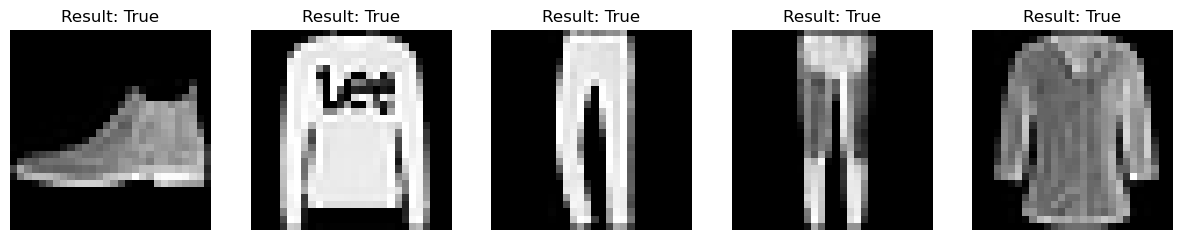

In [73]:
# Несколько примеров как работает модель

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img, label = test_dataset[i]
    predict = torch.argmax(model(img))
    axs[i].imshow(img.squeeze(), cmap='gray')
    axs[i].set_title(f'Result: {label == predict}')
    axs[i].axis('off')
plt.show()

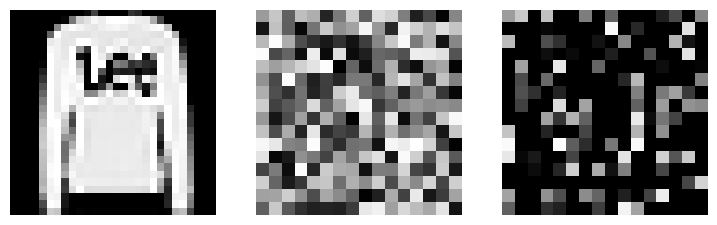

In [78]:
# Визуализируем выходы скрытых слоев

hidden_outputs = []
def hook_fn(module, input, output):
    hidden_outputs.append(output)

for layer in model:
    layer.register_forward_hook(hook_fn)

X_test, y_test = test_dataset[1]
model(X_test)

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

for i, img_tensor in enumerate([hidden_outputs[0][0], hidden_outputs[10][0], hidden_outputs[20][0]]):
    img = img_tensor.view(int(img_tensor.size(0)**0.5), -1).detach().numpy()
    img = Image.fromarray((img * 255).astype('uint8'))  # преобразование массива в изображение
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
plt.show()

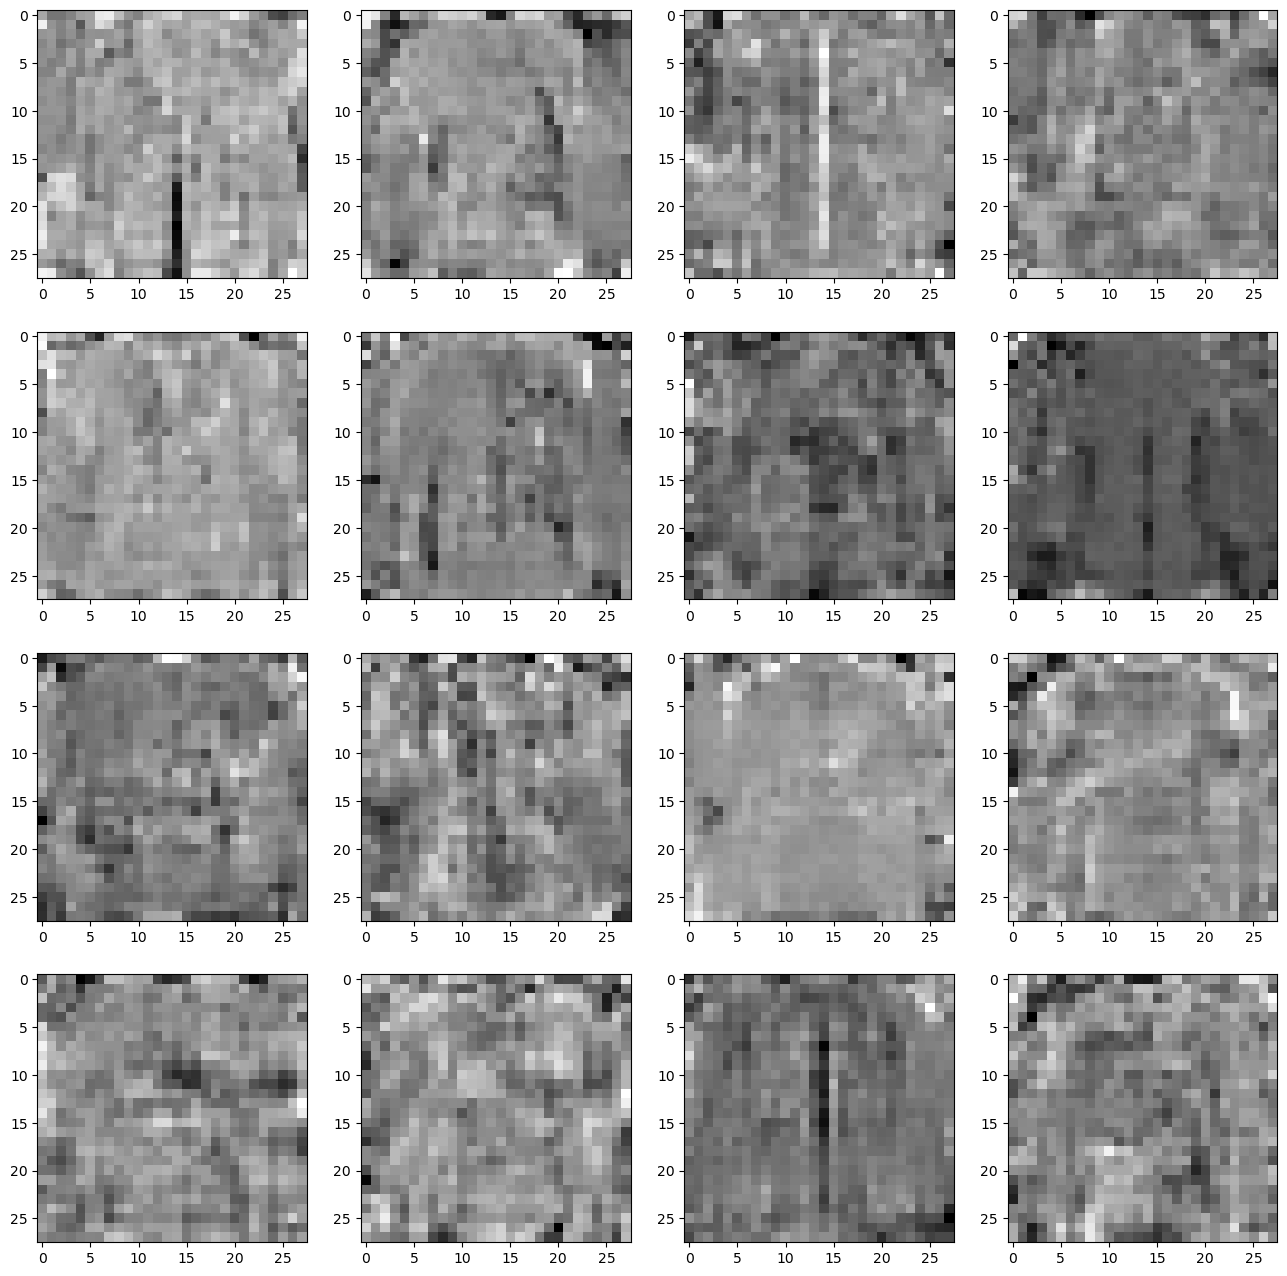

In [79]:
# Визуализируем веса первого слоя
layers = list(model.children())

layer_weights = [layer.weight.data.numpy() for layer in model if isinstance(layer, torch.nn.Linear)]

fig, axs = plt.subplots(4, 4, figsize=(16, 16))

for i, weights in enumerate(layer_weights[0][0:16]):
    img_tensor = torch.tensor(weights)
    img = img_tensor.view(int(img_tensor.size(0)**0.5), -1).detach().numpy()
    axs[math.floor(i/4)][i % 4].imshow(img, cmap='gray', aspect='auto')
plt.show()

In [80]:
# Поклассовая точность

class_correct = [0. for _ in range(len(LABELS))]
total_correct = [0. for _ in range(len(LABELS))]

with torch.no_grad():
    for images, labels in test:
        outputs = model(images)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(len(LABELS)):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(LABELS[i], class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/top: 77.78%
Accuracy of Trouser: 100.00%
Accuracy of Pullover: 87.50%
Accuracy of Dress: 100.00%
Accuracy of Coat: 93.75%
Accuracy of Sandal: 83.33%
Accuracy of Shirt: 54.55%
Accuracy of Sneaker: 87.50%
Accuracy of Bag: 100.00%
Accuracy of Ankle boot: 100.00%
